In [69]:
# %pip install ta

In [70]:
# conda install -c conda-forge mlxtend


# Set up

In [71]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import yfinance as yf
from bayes_opt import UtilityFunction
import warnings
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

pd.options.mode.chained_assignment = None  # ปิด SettingWithCopyWarning
pd.set_option('display.max_columns', None)

# Feature Engineering

In [72]:
# Indicator
# Basic stats
# time series
# observation
# set index , gold , another industrial index ,oil price ,s and p
# เงินการท่องเที่ยว
# อัตราแลกเปลี่ยน
# เงินเฟ้อ
# Tourism index



## Price and Index

In [73]:
from datetime import timedelta, datetime
import yfinance as yf  # Don't forget to import yfinance

# Stock Name
stock_name = 'ERW.BK'

# ตั้งค่าวันที่
cur_date = datetime.now().strftime('%Y-%m-%d')
date_60_days_ago = (datetime.now() - timedelta(days=59)).strftime('%Y-%m-%d')

# ดึงข้อมูล ERW.BK
df = yf.download(stock_name, start=date_60_days_ago, end=cur_date, interval='15m')

# ดึงข้อมูลสินค้าโภคภัณฑ์และดัชนีตลาดหลักทรัพย์
# ตัวอย่าง: ทองคำ (Gold), น้ำมัน (Crude Oil), SET Index, Dow Jones, S&P 500
# โปรดแทนที่ 'SYMBOL' ด้วยตัวย่อของแต่ละสินค้าหรือดัชนี
df_gold = yf.download('GC=F', start=date_60_days_ago, end=cur_date, interval='15m')
df_oil = yf.download('CL=F', start=date_60_days_ago, end=cur_date, interval='15m')
df_set = yf.download('^SET.BK', start=date_60_days_ago, end=cur_date, interval='15m')
df_dji = yf.download('^DJI', start=date_60_days_ago, end=cur_date, interval='15m')
df_sp500 = yf.download('^GSPC', start=date_60_days_ago, end=cur_date, interval='15m')

# เพิ่มคำนำหน้าในแต่ละ feature ของ DataFrame
df = df.add_prefix(f'{stock_name}_')
df_gold = df_gold.add_prefix('Gold_')
df_oil = df_oil.add_prefix('Oil_')
df_set = df_set.add_prefix('SET_')
df_dji = df_dji.add_prefix('DJI_')
df_sp500 = df_sp500.add_prefix('SP500_')

# ดึงข้อมูลดัชนี SET50
df_set50 = yf.download('^SET50.BK', start=date_60_days_ago, end=cur_date, interval='15m')

# ดึงข้อมูลดัชนี SET100
df_set100 = yf.download('^SET100.BK', start=date_60_days_ago, end=cur_date, interval='15m')

# เพิ่มคำนำหน้าในแต่ละ feature ของ DataFrame ของดัชนี SET50 และ SET100
df_set50 = df_set50.add_prefix('SET50_')
df_set100 = df_set100.add_prefix('SET100_')

# รวม DataFrame ทั้งหมดเข้าด้วยกัน โดยใช้วันที่เป็น index
df_combined = pd.concat([df, df_gold, df_oil, df_set, df_dji, df_sp500, df_set50, df_set100], axis=1)

# เลือกเฉพาะแถวที่อยู่ใน df_erw
df_selected = df_combined[df_combined[f'{stock_name}_Close'].notnull()]
df = df_selected

# แสดงผล DataFrame ที่เลือก
display(df.head(5))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,ERW.BK_Open,ERW.BK_High,ERW.BK_Low,ERW.BK_Close,ERW.BK_Adj Close,ERW.BK_Volume,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Adj Close,Gold_Volume,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Adj Close,Oil_Volume,SET_Open,SET_High,SET_Low,SET_Close,SET_Adj Close,SET_Volume,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj Close,DJI_Volume,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Adj Close,SP500_Volume,SET50_Open,SET50_High,SET50_Low,SET50_Close,SET50_Adj Close,SET50_Volume,SET100_Open,SET100_High,SET100_Low,SET100_Close,SET100_Adj Close,SET100_Volume
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-09 10:00:00,5.20,5.20,5.15,5.15,5.15,17900.0,1963.300049,1966.400024,1960.400024,1965.000000,1965.000000,6778.0,76.260002,76.629997,76.139999,76.620003,76.620003,9060.0,1408.530029,1408.530029,1400.790039,1402.660034,1402.660034,0.0,34105.480469,34129.738281,34020.199219,34038.589844,34038.589844,12683606.0,4388.319824,4391.080078,4374.479980,4378.359863,4378.359863,87995219.0,870.520020,870.520020,865.000000,866.729980,866.729980,0.0,1929.150024,1929.150024,1917.310059,1920.780029,1920.780029,0.0
2023-11-09 10:15:00,5.15,5.20,5.15,5.15,5.15,907200.0,1965.000000,1966.199951,1962.800049,1963.000000,1963.000000,3746.0,76.620003,76.919998,76.470001,76.870003,76.870003,8944.0,1402.380005,1404.319946,1400.829956,1401.630005,1401.630005,0.0,34038.761719,34041.511719,33999.289062,34012.191406,34012.191406,9524776.0,4378.379883,4379.290039,4373.470215,4374.209961,4374.209961,71084667.0,866.489990,868.020020,865.530029,866.200012,866.200012,0.0,1920.180054,1923.300049,1917.979980,1919.280029,1919.280029,0.0
2023-11-09 10:30:00,5.10,5.15,5.10,5.10,5.10,80800.0,1963.000000,1968.800049,1962.400024,1968.699951,1968.699951,6664.0,76.879997,77.070000,76.860001,76.959999,76.959999,11158.0,1401.520020,1401.880005,1394.569946,1394.569946,1394.569946,0.0,34011.988281,34025.078125,33983.250000,34011.839844,34011.839844,9093214.0,4374.330078,4376.279785,4370.560059,4375.959961,4375.959961,71871797.0,866.049988,866.390015,861.750000,862.030029,862.030029,0.0,1918.989990,1919.530029,1909.089966,1909.479980,1909.479980,0.0
2023-11-09 10:45:00,5.10,5.15,5.10,5.10,5.10,327800.0,1968.699951,1970.400024,1966.800049,1968.199951,1968.199951,5895.0,76.949997,77.160004,76.629997,76.800003,76.800003,11649.0,1394.609985,1396.640015,1394.030029,1396.030029,1396.030029,0.0,34011.441406,34062.410156,34003.101562,34056.828125,34056.828125,9787072.0,4375.950195,4379.569824,4373.279785,4379.569824,4379.569824,67262530.0,861.830017,863.969971,861.640015,863.700012,863.700012,0.0,1909.130005,1913.300049,1908.670044,1912.869995,1912.869995,0.0
2023-11-09 11:00:00,5.10,5.10,5.05,5.05,5.05,1715700.0,1968.099976,1968.599976,1965.900024,1966.400024,1966.400024,4926.0,76.790001,76.800003,76.099998,76.139999,76.139999,20637.0,1397.020020,1397.020020,1392.520020,1394.689941,1394.689941,0.0,34054.019531,34121.250000,34054.019531,34101.031250,34101.031250,8539581.0,4379.370117,4387.060059,4379.330078,4385.350098,4385.350098,60593421.0,863.650024,864.479980,860.840027,862.809998,862.809998,0.0,1914.229980,1914.229980,1906.810059,1910.699951,1910.699951,0.0


In [74]:
# Log Data Daily
df.to_csv(stock_name + cur_date +'_'+ date_60_days_ago+'.csv')

# last_dt_prefer = datetime.date(2024, 1, 6) # Adjust this
# last_dt_prefer_str = last_dt_prefer.strftime('%Y-%m-%d')
# date_60_days_ago_prefer = (last_dt_prefer - timedelta(days=59)).strftime('%Y-%m-%d')
# df = pd.read_csv(stock_name + last_dt_prefer_str +'_'+ date_60_days_ago_prefer+'.csv')

## Indicator

In [75]:
import pandas as pd
import ta

def calculate_indicators(df, windows, stock_name):
    # กำหนดคอลัมน์ที่จำเป็น
    global close_col
    close_col = f'{stock_name}_Close'
    low_col = f'{stock_name}_Low'
    high_col = f'{stock_name}_High'
    volume_col = f'{stock_name}_Volume'

    # ตัวชี้วัดทางเทคนิค
    for window in windows:
        # Simple and Exponential Moving Averages
        df[f'SMA_{window}'] = ta.trend.sma_indicator(df[close_col], window=window)
        df[f'EMA_{window}'] = ta.trend.ema_indicator(df[close_col], window=window)
        
        # Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(df[high_col], df[low_col], df[close_col], window=window, smooth_window=3)
        df[f'Stoch_%K_{window}'] = stoch.stoch()
        df[f'Stoch_%D_{window}'] = stoch.stoch_signal()

        # Relative Strength Index
        df[f'RSI_{window}'] = ta.momentum.rsi(df[close_col], window=window)

        # Williams %R
        df[f'WPR_{window}'] = ta.momentum.williams_r(df[high_col], df[low_col], df[close_col], lbp=window)

        # Average True Range
        df[f'ATR_{window}'] = ta.volatility.average_true_range(df[high_col], df[low_col], df[close_col], window=window)

        # Commodity Channel Index
        df[f'CCI_{window}'] = ta.trend.cci(df[high_col], df[low_col], df[close_col], window=window)

        # Bollinger Bands
        bollinger = ta.volatility.BollingerBands(df[close_col], window=window, window_dev=2)
        df[f'Bollinger_mavg_{window}'] = bollinger.bollinger_mavg()
        df[f'Bollinger_hband_{window}'] = bollinger.bollinger_hband()
        df[f'Bollinger_lband_{window}'] = bollinger.bollinger_lband()

    # ตัวชี้วัด MACD
    macd = ta.trend.MACD(df[close_col], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_diff'] = macd.macd_diff()


    # ตัวชี้วัดเพิ่มเติม
    df['Momentum'] = df[close_col].diff(4)
    df['ROC'] = df[close_col].pct_change(periods=4)
    df['OBV'] = ta.volume.on_balance_volume(df[close_col], df[volume_col])
    df['Close_pct_change'] = df[close_col].pct_change()

    # Time-based Features
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    # ลบข้อมูล NaN
    df.dropna(inplace=True)

# กำหนด windows size
windows = [5, 10, 15, 20, 25]

# ใช้งานฟังก์ชันกับ DataFrame
calculate_indicators(df, windows, stock_name)

# แสดงผล DataFrame
display(df.head(5))
print(df.count())


,ERW.BK_Open,ERW.BK_High,ERW.BK_Low,ERW.BK_Close,ERW.BK_Adj Close,ERW.BK_Volume,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Adj Close,Gold_Volume,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Adj Close,Oil_Volume,SET_Open,SET_High,SET_Low,SET_Close,SET_Adj Close,SET_Volume,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj Close,DJI_Volume,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Adj Close,SP500_Volume,SET50_Open,SET50_High,SET50_Low,SET50_Close,SET50_Adj Close,SET50_Volume,SET100_Open,SET100_High,SET100_Low,SET100_Close,SET100_Adj Close,SET100_Volume,SMA_5,EMA_5,Stoch_%K_5,Stoch_%D_5,RSI_5,WPR_5,ATR_5,CCI_5,Bollinger_mavg_5,Bollinger_hband_5,Bollinger_lband_5,SMA_10,EMA_10,Stoch_%K_10,Stoch_%D_10,RSI_10,WPR_10,ATR_10,CCI_10,Bollinger_mavg_10,Bollinger_hband_10,Bollinger_lband_10,SMA_15,EMA_15,Stoch_%K_15,Stoch_%D_15,RSI_15,WPR_15,ATR_15,CCI_15,Bollinger_mavg_15,Bollinger_hband_15,Bollinger_lband_15,SMA_20,EMA_20,Stoch_%K_20,Stoch_%D_20,RSI_20,WPR_20,ATR_20,CCI_20,Bollinger_mavg_20,Bollinger_hband_20,Bollinger_lband_20,SMA_25,EMA_25,Stoch_%K_25,Stoch_%D_25,RSI_25,WPR_25,ATR_25,CCI_25,Bollinger_mavg_25,Bollinger_hband_25,Bollinger_lband_25,MACD,MACD_signal,MACD_diff,Momentum,ROC,OBV,Close_pct_change,hour_of_day,day_of_week
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-10 15:15:00,5.05,5.10,5.05,5.10,5.10,1611000.0,1940.199951,1940.800049,1939.699951,1939.900024,1939.900024,614.0,77.279999,77.339996,77.250000,77.269997,77.269997,1152.0,1398.459961,1399.099976,1396.969971,1397.910034,1397.910034,0.0,34220.378906,34267.671875,34204.640625,34267.671875,34267.671875,9220593.0,4407.600098,4412.910156,4405.569824,4412.649902,4412.649902,68946000.0,865.340027,866.260010,864.510010,865.010010,865.010010,0.0,1915.579956,1916.780029,1913.260010,1914.729980,1914.729980,0.0,5.09,5.090739,66.666561,66.666561,59.187542,-33.333439,0.059311,-0.000079,5.09,5.187980,4.992020,5.065,5.074884,70.588136,70.588136,55.707271,-29.411864,0.055659,4.772068e+01,5.065,5.15500,4.97500,5.046667,5.068554,70.588136,70.588136,53.463683,-29.411864,0.054533,81.800369,5.046667,5.139523,4.953811,5.0550,5.067603,70.588136,70.588136,52.150059,-29.411864,0.054404,62.164963,5.0550,5.143882,4.966118,5.058,5.069267,70.588136,70.588136,51.307980,-29.411864,0.054561,55.414885,5.058,5.141331,4.974669,0.001675,-0.010398,0.012072,0.10,0.020000,10774104.0,0.000000,15,4
2023-11-10 15:30:00,5.10,5.10,5.05,5.05,5.05,53800.0,1940.000000,1940.000000,1939.500000,1939.800049,1939.800049,960.0,77.269997,77.300003,77.260002,77.290001,77.290001,2039.0,1397.670044,1399.439941,1396.930054,1398.689941,1398.689941,0.0,34268.128906,34290.019531,34261.578125,34283.429688,34283.429688,10761736.0,4412.700195,4414.939941,4411.359863,4414.689941,4414.689941,90390000.0,865.010010,866.320007,864.309998,866.320007,866.320007,0.0,1914.229980,1917.280029,1913.359985,1916.459961,1916.459961,0.0,5.10,5.077159,0.000000,44.444374,42.199251,-100.000000,0.057449,-95.237852,5.10,5.163245,5.036755,5.070,5.070360,33.333439,58.169904,47.381537,-66.666561,0.055093,2.220451e-12,5.070,5.15000,4.99000,5.050000,5.066235,41.176553,60.784275,47.670444,-58.823447,0.054231,39.225430,5.050000,5.139443,4.960557,5.0525,5.065926,41.176553,60.784275,47.465935,-58.823447,0.054184,29.081599,5.0525,5.138958,4.966042,5.058,5.067785,41.176553,60.784275,47.228213,-58.823447,0.054379,17.768995,5.058,5.141331,4.974669,-0.000160,-0.008350,0.008190,-0.10,-0.019417,10720304.0,-0.009804,15,4
2023-11-10 15:45:00,5.05,5.10,5.05,5.05,5.05,457201.0,1939.900024,1940.300049,1939.500000,1940.199951,1940.199951,1045.0,77.290001,77.339996,77.220001,77.250000,77.250000,1239.0,1398.250000,1399.500000,1393.390015,1393.390015,1393.390015,0.0,34283.671875,34310.359375,34271.988281,34286.519531,34286.519531,33535611.0,4414.729980,4418.029785,4413.629883,4415.890137,4415.890137,257745000.0,865.729980,866.919983,862.599976,862.770020,862.770020,0.0,1915.239990,1918.099976,190

ERW.BK_Open         531
ERW.BK_High         531
ERW.BK_Low          531
ERW.BK_Close        531
ERW.BK_Adj Close    531
                   ... 
ROC                 531
OBV                 531
Close_pct_change    531
hour_of_day         531
day_of_week         531
Length: 112, dtype: int64


## Label

In [76]:
df['y'] = np.where(df[f'{stock_name}_Close'].shift(-1) > df[f'{stock_name}_Close'],1,-1)
df.tail(5)

,ERW.BK_Open,ERW.BK_High,ERW.BK_Low,ERW.BK_Close,ERW.BK_Adj Close,ERW.BK_Volume,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Adj Close,Gold_Volume,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Adj Close,Oil_Volume,SET_Open,SET_High,SET_Low,SET_Close,SET_Adj Close,SET_Volume,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj Close,DJI_Volume,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Adj Close,SP500_Volume,SET50_Open,SET50_High,SET50_Low,SET50_Close,SET50_Adj Close,SET50_Volume,SET100_Open,SET100_High,SET100_Low,SET100_Close,SET100_Adj Close,SET100_Volume,SMA_5,EMA_5,Stoch_%K_5,Stoch_%D_5,RSI_5,WPR_5,ATR_5,CCI_5,Bollinger_mavg_5,Bollinger_hband_5,Bollinger_lband_5,SMA_10,EMA_10,Stoch_%K_10,Stoch_%D_10,RSI_10,WPR_10,ATR_10,CCI_10,Bollinger_mavg_10,Bollinger_hband_10,Bollinger_lband_10,SMA_15,EMA_15,Stoch_%K_15,Stoch_%D_15,RSI_15,WPR_15,ATR_15,CCI_15,Bollinger_mavg_15,Bollinger_hband_15,Bollinger_lband_15,SMA_20,EMA_20,Stoch_%K_20,Stoch_%D_20,RSI_20,WPR_20,ATR_20,CCI_20,Bollinger_mavg_20,Bollinger_hband_20,Bollinger_lband_20,SMA_25,EMA_25,Stoch_%K_25,Stoch_%D_25,RSI_25,WPR_25,ATR_25,CCI_25,Bollinger_mavg_25,Bollinger_hband_25,Bollinger_lband_25,MACD,MACD_signal,MACD_diff,Momentum,ROC,OBV,Close_pct_change,hour_of_day,day_of_week,y
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-05 12:15:00,5.20,5.25,5.2,5.25,5.25,270600.0,2050.500000,2052.300049,2047.800049,2048.300049,2048.300049,3184.0,73.839996,73.930000,73.639999,73.660004,73.660004,4888.0,1431.290039,1431.469971,1429.359985,1430.560059,1430.560059,0.0,37375.929688,37385.261719,37347.480469,37350.468750,37350.468750,6434746.0,4695.419922,4696.839844,4690.100098,4690.700195,4690.700195,45079284.0,877.049988,877.150024,875.289978,876.789978,876.789978,0.0,1945.989990,1947.319946,1943.250000,1945.589966,1945.589966,0.0,5.24,5.248453,50.0,50.000000,48.060458,-50.0,0.068006,-41.666667,5.24,5.28000,5.20000,5.250,5.253827,50.0,38.888960,47.807249,-50.0,0.067443,-83.333333,5.250,5.294722,5.205278,5.270000,5.257645,33.333439,33.333439,48.621594,-66.666561,0.066056,-100.694465,5.270000,5.341181,5.198819,5.2675,5.259378,33.333439,33.333439,49.175232,-66.666561,0.064787,-79.096051,5.2675,5.340129,5.194871,5.264,5.259965,33.333439,33.333439,49.570490,-66.666561,0.063506,-73.302486,5.264,5.330453,5.197547,-0.004313,0.000117,-0.004430,0.05,0.009615,215753307.0,0.000000,12,4,-1
2024-01-05 14:15:00,5.25,5.25,5.2,5.20,5.20,590800.0,2056.100098,2056.199951,2054.100098,2054.300049,2054.300049,908.0,73.900002,74.010002,73.750000,73.760002,73.760002,15922.0,1430.869995,1430.869995,1430.770020,1430.770020,1430.770020,0.0,37506.800781,37511.488281,37467.289062,37474.859375,37474.859375,11272802.0,4704.069824,4705.069824,4698.129883,4699.270020,4699.270020,51791000.0,876.840027,876.840027,876.760010,876.760010,876.760010,0.0,1946.180054,1946.180054,1946.010010,1946.010010,1946.010010,0.0,5.24,5.232302,0.0,33.333333,28.125136,-100.0,0.064405,-166.666667,5.24,5.28000,5.20000,5.245,5.244040,0.0,27.777813,38.561730,-100.0,0.065699,-125.925926,5.245,5.298852,5.191148,5.263333,5.250440,0.000000,22.222293,42.692269,-100.000000,0.064986,-127.451029,5.263333,5.340506,5.186161,5.2650,5.253723,0.000000,22.222293,44.826938,-100.000000,0.064048,-117.647108,5.2650,5.343103,5.186897,5.262,5.255352,0.000000,22.222293,46.119618,-100.000000,0.062966,-111.967756,5.262,5.332880,5.191120,-0.008435,-0.001594,-0.006841,-0.05,-0.009524,215162507.0,-0.009524,14,4,-1
2024-01-05 14:30:00,5.20,5.25,5.2,5.20,5.20,1276230.0,2054.199951,2055.199951,2053.199951,2053.500000,2053.500000,714.0,73.760002,73.790001,73.660004,73.779999,73.779999,4509.0,1431.699951,1431.699951,1429.949951,1429.949951,1429.949951,0.0,37474.410156,37500.070312,37440.960938,37448.769531,37448.769531,6859581.0,4699.270020,4701.819824,4693.850098,4694.580078,4694.580078,48581000.0,877.539978,877.539978,875.760010,876.210022,876.210022,0.0,1947.640015,1947.640015,1944.449951,1944.449951,

In [77]:
# Filter columns that's too unique
no_variation_cols = []
for i in df.columns:
    # print( i ,':',len(df[i].unique()) )
    if (len(df[i].unique()) <= 4) & (i != 'y'):
        no_variation_cols.append(i)
print(no_variation_cols)

selected_cols = list(set(df.columns) - set(no_variation_cols))
df = df[selected_cols]
df.head()
print(selected_cols)

['SET_Volume', 'SET50_Volume', 'SET100_Volume']
['RSI_20', 'SET_Open', 'DJI_Close', 'Gold_Adj Close', 'WPR_5', 'ATR_20', 'ROC', 'RSI_25', 'ERW.BK_Adj Close', 'Oil_Low', 'Gold_Open', 'SET100_High', 'ERW.BK_High', 'Stoch_%D_15', 'WPR_20', 'ATR_10', 'SMA_25', 'Gold_High', 'Stoch_%K_25', 'SP500_Volume', 'SET100_Adj Close', 'SP500_Close', 'ERW.BK_Close', 'RSI_10', 'SP500_Adj Close', 'Close_pct_change', 'day_of_week', 'SP500_High', 'SP500_Open', 'EMA_15', 'Stoch_%K_10', 'Bollinger_hband_25', 'SET_Adj Close', 'CCI_20', 'RSI_15', 'SET_Low', 'Bollinger_mavg_5', 'WPR_25', 'SMA_10', 'SET50_Close', 'ATR_5', 'Bollinger_mavg_10', 'Oil_Adj Close', 'Bollinger_hband_15', 'Bollinger_lband_15', 'Gold_Volume', 'SET100_Close', 'SMA_5', 'y', 'SET50_Open', 'Bollinger_lband_10', 'SET_High', 'SET50_Adj Close', 'DJI_Adj Close', 'ATR_15', 'Stoch_%D_20', 'SET50_Low', 'EMA_25', 'WPR_15', 'Stoch_%K_5', 'hour_of_day', 'Stoch_%D_10', 'Gold_Low', 'Bollinger_hband_20', 'CCI_5', 'EMA_5', 'OBV', 'RSI_5', 'CCI_10', 'MACD_

# EDA


In [78]:
print(df['y'].value_counts())

# Check whether y column is correct or not
rand_row = np.random.randint(1,100)
df[[close_col,'y']].iloc[rand_row : rand_row +7 , :]

y
-1    422
 1    109
Name: count, dtype: int64


,ERW.BK_Close,y
Datetime,,
2023-11-16 15:15:00,5.40,-1
2023-11-16 15:30:00,5.40,-1
2023-11-16 15:45:00,5.40,1
2023-11-17 10:00:00,5.45,-1
2023-11-17 10:15:00,5.45,-1
2023-11-17 10:30:00,5.40,-1
2023-11-17 10:45:00,5.40,1


# TF(Scale, Ft selection )

## Train test split

In [79]:
split_index = int( 1 * len(df))
df_test = df.iloc[split_index:]
df = df.iloc[:split_index]
print(len(df) , len(df_test))

531 0


## Robust Scaler

In [80]:
from sklearn.preprocessing import RobustScaler

def fit_robust_scaler(df, y_column):
    """
    Fit a RobustScaler to the DataFrame (except for the target column) and return the scaler.

    Parameters:
    df (DataFrame): The DataFrame used to fit the scaler.
    y_column (str): The name of the target column.

    Returns:
    RobustScaler: The fitted scaler.
    """
    # Copy the DataFrame to avoid modifying the original one
    df_to_fit = df.drop(y_column, axis=1)

    # Initialize and fit RobustScaler
    scaler = RobustScaler()
    scaler.fit(df_to_fit)

    return scaler

def transform_with_scaler(df, scaler, y_column):
    """
    Transform a DataFrame using a provided RobustScaler.

    Parameters:
    df (DataFrame): The DataFrame to be transformed.
    scaler (RobustScaler): The scaler to use for transformation.
    y_column (str): The name of the target column.

    Returns:
    DataFrame: The scaled DataFrame with the target column.
    """
    df_scaled = df.copy()
    y = df_scaled.pop(y_column)
    df_scaled = pd.DataFrame(scaler.transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index)
    df_scaled[y_column] = y

    return df_scaled

# Example usage
scaler = fit_robust_scaler(df, 'y')
robust_tf_df = transform_with_scaler(df, scaler, 'y')
try:
    robust_tf_test_df = transform_with_scaler(df_test, scaler, 'y')
except:
    pass


display(robust_tf_df.head())

# จำนวนแถวที่ทุกคอลัมน์ไม่เป็น null
num_rows_without_nulls = len(robust_tf_df.dropna())
print("จำนวนแถวที่ไม่มีค่า null ในทุกคอลัมน์:", num_rows_without_nulls)

,RSI_20,SET_Open,DJI_Close,Gold_Adj Close,WPR_5,ATR_20,ROC,RSI_25,ERW.BK_Adj Close,Oil_Low,Gold_Open,SET100_High,ERW.BK_High,Stoch_%D_15,WPR_20,ATR_10,SMA_25,Gold_High,Stoch_%K_25,SP500_Volume,SET100_Adj Close,SP500_Close,ERW.BK_Close,RSI_10,SP500_Adj Close,Close_pct_change,day_of_week,SP500_High,SP500_Open,EMA_15,Stoch_%K_10,Bollinger_hband_25,SET_Adj Close,CCI_20,RSI_15,SET_Low,Bollinger_mavg_5,WPR_25,SMA_10,SET50_Close,ATR_5,Bollinger_mavg_10,Oil_Adj Close,Bollinger_hband_15,Bollinger_lband_15,Gold_Volume,SET100_Close,SMA_5,SET50_Open,Bollinger_lband_10,SET_High,SET50_Adj Close,DJI_Adj Close,ATR_15,Stoch_%D_20,SET50_Low,EMA_25,WPR_15,Stoch_%K_5,hour_of_day,Stoch_%D_10,Gold_Low,Bollinger_hband_20,CCI_5,EMA_5,OBV,RSI_5,CCI_10,MACD_signal,ERW.BK_Open,SMA_20,ERW.BK_Low,Bollinger_lband_5,Oil_Volume,DJI_Open,DJI_Volume,SMA_15,Bollinger_lband_20,WPR_10,ATR_25,CCI_15,DJI_High,Stoch_%K_15,EMA_10,Gold_Close,SP500_Low,SET50_High,Bollinger_mavg_25,DJI_Low,Stoch_%D_5,Bollinger_lband_25,MACD,Oil_Close,SET_Close,Momentum,EMA_20,Oil_High,Bollinger_hband_10,SET100_Open,MACD_diff,Oil_Open,CCI_25,Bollinger_mavg_20,SET100_Low,Bollinger_mavg_15,Stoch_%D_25,Stoch_%K_20,ERW.BK_Volume,Bollinger_hband_5,y
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-10 15:15:00,0.110830,-0.020362,-0.919037,-1.770800,0.222224,-0.062453,1.054971,0.061302,-0.666666,0.856429,-1.764010,-0.082203,-1.000000,0.617635,0.617640,-0.026664,-0.973332,-1.796753,0.552629,0.263677,-0.075388,-1.005911,-0.666666,0.337707,-1.005911,0.000000,1.0,-1.020989,-1.025298,-0.914775,0.494113,-0.867709,-0.049760,0.422200,0.263879,-0.028633,-0.733332,0.552629,-0.903224,-0.040660,0.154376,-0.903224,0.834804,-0.827725,-1.089673,-0.516538,-0.075388,-0.733332,-0.035614,-1.067777,-0.055676,-0.040660,-0.919037,-0.049562,0.617641,-0.009006,-0.945674,0.617640,0.222224,1.000000,0.529406,-1.814248,-0.836984,0.144490,-0.714325,-1.557053,0.378489,0.356885,-0.464162,-0.999997,-0.983605,-0.999997,-0.987373,-0.560295,-0.936588,0.430106,-1.021738,-0.958114,0.494113,-0.081234,0.549450,-0.920554,0.617640,-0.849909,-1.770800,-1.033988,-0.044376,-0.973332,-0.942608,0.379746,-0.898158,-0.031553,0.834804,-0.049760,1.000005,-0.918881,0.791615,-0.680257,-0.054431,1.270606,0.808355,0.352058,-0.983605,-0.052632,-1.021738,0.617640,0.617640,1.675475,-0.440437,-1
2023-11-10 15:30:00,-0.351624,-0.047619,-0.911503,-1.772497,-0.666664,-0.077470,-1.024244,-0.429547,-0.999997,0.858927,-1.767405,-0.070220,-1.000000,0.323522,-0.264702,-0.060273,-0.973332,-1.810417,-0.236840,1.057486,-0.034505,-0.994092,-0.999997,-0.220242,-0.994092,-0.009804,1.0,-1.009347,-0.995876,-0.929731,-0.399996,-0.867709,-0.023178,0.209864,-0.213607,-0.030010,-0.666665,-0.236840,-0.870966,0.025922,0.055976,-0.870966,0.839849,-0.828205,-1.047384,-0.394792,-0.034505,-0.666665,-0.052168,-0.967777,-0.043697,0.025922,-0.911503,-0.067852,0.323526,-0.019015,-0.955782,-0.264702,-0.666664,1.000000,0.210082,-1.817854,-0.867216,-0.516036,-0.800414,-1.557767,-0.243993,0.060823,-0.386506,-0.666666,-0.999999,-0.999997,-0.707784,-0.420929,-0.913864,0.865141,-0.999999,-0.958572,-0.399996,-0.094826,0.279137,-0.909922,-0.264702,-0.878756,-1.772497,-1.000492,-0.041316,-0.973332,-0.915137,-0.126582,-0.898158,-0.094557,0.839849,-0.023178,-1.000005,-0.929962,0.781752,-0.711570,-0.086240,0.887726,0.805897,0.119089,-0.999999,-0.050304,-0.999999,0.323526,-0.264702,-0.168638,-0.599148,-1
2023-11-10 15:45:00,-0.351624,-0.027607,-0.910026,-1.765708,-0.666664,-0.091736,-0.517140,-0.429547,-0.999997,0.848939,-1.769102,-0.050569,-1.000000,0.029409,-0.264702,-0.090521,-0.973332,-1.805292,-0.236840,7.252600,-0.218835,-0.987138,-0.999997,-0.220242,-0.987138,0.000000,1.0,-0.991625,-0.984167,-0.942817,-0.399996,-0.867709,-0.203817,0.227894,-0.213607,-0.152123,-0.799998,-0.236840,-0.870966,-0.154510,-0.022744,-0.870966,0.829761,-0.828205,-1.047384,-0.364884,-0.218835,-0.799998,-0.016053,-0.967777,-0.041580,-0.15

จำนวนแถวที่ไม่มีค่า null ในทุกคอลัมน์: 531


# Feature Selection

## FtImpRF + MultiCorr

### Feature Importance using RF

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
import pandas as pd
import numpy as np

def calculate_feature_importance(df, y_column, n_splits):
    # แยก DataFrame เป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column]

    # สร้าง TimeSeriesSplit ด้วย n_splits ที่ระบุ
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # สร้างโมเดล Random Forest
    rf = RandomForestClassifier()

    # ตั้งค่าพารามิเตอร์สำหรับ Grid Search
    param_grid = {
        'n_estimators': [10, 50, 100, 500],
        'max_depth': [None, 10, 20, 30, 70, 100],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # ใช้ Grid Search ด้วย TimeSeriesSplit เพื่อหาพารามิเตอร์ที่ดีที่สุด
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, n_jobs=-1)
    grid_search.fit(X, y)

    # สร้างโมเดลด้วยพารามิเตอร์ที่ดีที่สุด
    best_rf = grid_search.best_estimator_

    # คำนวณ feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # ตรวจสอบประสิทธิภาพโมเดลด้วย cross-validation และ TimeSeriesSplit
    cv_scores = cross_val_score(best_rf, X, y, cv=tscv, scoring='roc_auc')
    avg_cv_score = np.mean(cv_scores)
    print("cv score : ",cv_scores)
    print("cv avg score : ",avg_cv_score)

    return feature_importance, avg_cv_score


feature_importance_df, avg_cv_score = calculate_feature_importance(robust_tf_df, 'y', 5)
display(feature_importance_df)
print(f'Average AUC-ROC Score: {avg_cv_score}')


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
783 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _valida

cv score :  [0.70422535 0.6531746  0.66392694 0.59895833 0.67093106]
cv avg score :  0.6582432576501285


,Feature,Importance
66,RSI_5,0.024732
25,Close_pct_change,0.023276
99,MACD_diff,0.019691
75,DJI_Volume,0.019492
34,RSI_15,0.019401
...,...,...
71,ERW.BK_Low,0.002119
12,ERW.BK_High,0.001767
69,ERW.BK_Open,0.001351
26,day_of_week,0.001281


Average AUC-ROC Score: 0.6582432576501285


### Feature Importance using LIGHT GBM

In [82]:
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import RandomizedSearchCV, cross_val_score, TimeSeriesSplit
# import pandas as pd
# import numpy as np

# def calculate_feature_importance_with_lgbm(df, y_column, n_splits):
#     # แยก DataFrame เป็น features และ target
#     X = df.drop(y_column, axis=1)
#     y = df[y_column]

#     # แปลงค่า target เป็น 0 และ 1
#     y = y.replace(-1, 0)

#     # สร้าง TimeSeriesSplit
#     tscv = TimeSeriesSplit(n_splits=n_splits)

#     # สร้างโมเดล LightGBM
#     lgbm = LGBMClassifier(verbose=-1)

#     # ตั้งค่าพารามิเตอร์สำหรับ Random Search
#     param_dist = {
#         'n_estimators': [100, 200, 500],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'num_leaves': [31, 50, 100],
#         'max_depth': [-1, 10, 20],
#         'min_child_samples': [20, 30, 50]
#     }

#     # ใช้ Random Search ด้วย TimeSeriesSplit เพื่อหาพารามิเตอร์ที่ดีที่สุด
#     random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=100, cv=tscv, n_jobs=-1, random_state=42)
#     random_search.fit(X, y)

#     # สร้างโมเดลด้วยพารามิเตอร์ที่ดีที่สุด
#     best_lgbm = random_search.best_estimator_

#     # คำนวณ AUC-ROC score โดยใช้ cross validation กับ TimeSeriesSplit
#     cv_scores = cross_val_score(best_lgbm, X, y, cv=tscv, scoring='roc_auc')
#     avg_cv_score = np.mean(cv_scores)
#     print('cv score :', cv_scores)
#     print(f'Average AUC-ROC Score: {avg_cv_score}')

#     # คำนวณ feature importance
#     feature_importance = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': best_lgbm.feature_importances_
#     }).sort_values(by='Importance', ascending=False)
#     print("cv score : ",cv_scores)
#     print("cv avg score : ",avg_cv_score)

#     return feature_importance, avg_cv_score

# # # การใช้งานฟังก์ชัน
# # n_splits = 5  # กำหนดจำนวนการแบ่งข้อมูล
# # feature_importance_df, avg_cv_score = calculate_feature_importance_with_lgbm(robust_tf_df, 'y', n_splits)
# # display(feature_importance_df)



### Feature Importance using XGBOOST

In [83]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import RandomizedSearchCV, cross_val_score, TimeSeriesSplit
# import pandas as pd
# import numpy as np

# def calculate_feature_importance_with_xgboost(df, y_column, n_splits):
#     # แยก DataFrame เป็น features และ target
#     X = df.drop(y_column, axis=1)
#     y = df[y_column]

#     # แปลงค่า target เป็น 0 และ 1
#     y = y.replace(-1, 0)

#     # สร้าง TimeSeriesSplit
#     tscv = TimeSeriesSplit(n_splits=n_splits)

#     # สร้างโมเดล XGBoost
#     xgb = XGBClassifier(verbosity=0, use_label_encoder=False)

#     # ตั้งค่าพารามิเตอร์สำหรับ Random Search
#     param_dist = {
#         'n_estimators': [100, 200, 500],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 6, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.7, 0.8, 0.9],
#         'colsample_bytree': [0.7, 0.8, 0.9]
#     }

#     # ใช้ Random Search ด้วย TimeSeriesSplit เพื่อหาพารามิเตอร์ที่ดีที่สุด
#     random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, cv=tscv, n_jobs=-1)
#     random_search.fit(X, y)

#     # สร้างโมเดลด้วยพารามิเตอร์ที่ดีที่สุด
#     best_xgb = random_search.best_estimator_

#     # คำนวณ AUC-ROC score โดยใช้ cross validation กับ TimeSeriesSplit
#     cv_scores = cross_val_score(best_xgb, X, y, cv=tscv, scoring='roc_auc')
#     avg_cv_score = np.mean(cv_scores)
#     print('cv score :',cv_scores)
#     print(f'Average AUC-ROC Score: {avg_cv_score}')

#     # คำนวณ feature importance
#     feature_importance = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': best_xgb.feature_importances_
#     }).sort_values(by='Importance', ascending=False)

#     return feature_importance, avg_cv_score

# # # การใช้งานฟังก์ชัน
# # n_splits = 5  # กำหนดจำนวนการแบ่งข้อมูล
# # feature_importance_df, avg_cv_score = calculate_feature_importance_with_xgboost(robust_tf_df, 'y', n_splits)
# # display(feature_importance_df)
# # print(f'Average AUC-ROC Score: {avg_cv_score}')


### MultiCorr


In [84]:
def calculate_vif_and_correlation(df):
    # คำนวณ VIF
    def calculate_vif(dataframe):
        vif_data = pd.DataFrame()
        vif_data["feature"] = dataframe.columns
        vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(len(dataframe.columns))]
        return vif_data

    # สร้าง DataFrame ของค่า correlation แบบสัมบูรณ์
    correlation_matrix = df.corr().abs()

    # คำนวณ VIF
    vif_data = calculate_vif(df)

    # สร้าง DataFrame สำหรับค่า correlation และ VIF
    correlation_pairs = correlation_matrix.unstack().reset_index()
    correlation_pairs.columns = ['ft1', 'ft2', 'absolute_correlation']
    correlation_pairs = correlation_pairs[correlation_pairs['ft1'] != correlation_pairs['ft2']]

    # รวม VIF และ correlation
    result_df = correlation_pairs.merge(vif_data, left_on='ft1', right_on='feature')
    result_df = result_df.drop(columns=['feature']).sort_values(by='absolute_correlation', ascending=False)

    return result_df

# ใช้งานฟังก์ชัน
# สมมติว่า df เป็น DataFrame ที่คุณต้องการวิเคราะห์
multicorr_df = calculate_vif_and_correlation(robust_tf_df)

display(multicorr_df.head(10) ) 

/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,ft1,ft2,absolute_correlation,VIF
9159,Gold_Close,Gold_Adj Close,1.0,inf
4507,Bollinger_mavg_10,SMA_10,1.0,inf
6294,WPR_15,Stoch_%K_15,1.0,inf
10070,Oil_Close,Oil_Adj Close,1.0,inf
2312,SP500_Close,SP500_Adj Close,1.0,inf
3970,Bollinger_mavg_5,SMA_5,1.0,inf
3347,Stoch_%K_10,WPR_10,1.0,inf
410,Gold_Adj Close,Gold_Close,1.0,inf
2225,SET100_Adj Close,SET100_Close,1.0,inf
11568,Stoch_%K_20,WPR_20,1.0,inf


In [85]:
ft_imp_quantile_threshold = 0.9
ft_imp_threshold = feature_importance_df['Importance'].quantile(ft_imp_quantile_threshold)
ft_imp_selected_df = feature_importance_df[feature_importance_df['Importance'] >= ft_imp_threshold]
# display(ft_imp_selected_df)
ft_imp_selected_list = ft_imp_selected_df.iloc[:,0].values

# กำหนดค่า Threshold สำหรับค่าสหสัมพันธ์
correlation_threshold = 0.5

# คัดเลือกเฉพาะคู่ของคุณสมบัติที่มีค่าสหสัมพันธ์สูงกว่า Threshold
high_correlation_pairs = multicorr_df[
    (multicorr_df['absolute_correlation'] > correlation_threshold) &
    (multicorr_df['ft1'].isin(ft_imp_selected_list)) & 
    (multicorr_df['ft2'].isin(ft_imp_selected_list))
]

# ตัดสินใจเลือกคุณสมบัติที่มีค่า feature importance สูงที่สุด
selected_features = []
for _, row in high_correlation_pairs.iterrows():
    ft1_importance = feature_importance_df.loc[feature_importance_df['Feature'] == row['ft1'], 'Importance'].values[0]
    ft2_importance = feature_importance_df.loc[feature_importance_df['Feature'] == row['ft2'], 'Importance'].values[0]

    if ft1_importance > ft2_importance:
        selected_features.append(row['ft1'])
    else:
        selected_features.append(row['ft2'])

# ลบคุณสมบัติที่ซ้ำกัน
selected_features_by_ftimp_multicorr_list = list(set(selected_features))

print("Selected Features for Modeling:", selected_features)

robust_tf_ftimp_mulcorr_df = robust_tf_df[selected_features_by_ftimp_multicorr_list + ['y']]
print("Num of Ft selected :" , len(selected_features))


Selected Features for Modeling: ['RSI_15', 'RSI_15', 'DJI_Volume', 'DJI_Volume', 'RSI_15', 'RSI_15', 'RSI_5', 'RSI_5', 'RSI_10', 'RSI_10', 'RSI_5', 'RSI_5', 'CCI_10', 'CCI_10', 'RSI_5', 'RSI_5', 'RSI_10', 'RSI_10', 'MACD_diff', 'MACD_diff', 'RSI_5', 'RSI_5', 'RSI_5', 'RSI_5', 'RSI_5', 'RSI_5', 'RSI_15', 'RSI_15', 'MACD_diff', 'MACD_diff', 'MACD_diff', 'MACD_diff', 'RSI_10', 'RSI_10', 'CCI_10', 'CCI_10', 'MACD_diff', 'MACD_diff', 'RSI_15', 'RSI_15', 'Close_pct_change', 'Close_pct_change', 'RSI_5', 'RSI_5']
Num of Ft selected : 44


## RFE

In [86]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# สร้างข้อมูลตัวอย่าง
X = robust_tf_df.drop('y', axis=1)
y = robust_tf_df['y'].values.ravel()  # ใช้ .values.ravel() เพื่อแปลงเป็น array 1D

# สร้างโมเดล
model = RandomForestClassifier()

# RFE
selector = RFE(model, n_features_to_select=20, step=1)
selector = selector.fit(X, y)

# คุณสมบัติที่เลือก
selected_features = selector.support_
print("Selected Features: ", X.columns[selected_features])

selected_features_by_rfe_list = list(X.columns[selected_features])
robust_tf_rfe_df = robust_tf_df[selected_features_by_rfe_list + ['y']]

Selected Features:  Index(['SET_Open', 'RSI_25', 'Oil_Low', 'ATR_10', 'SP500_Volume', 'RSI_10',
       'Close_pct_change', 'Bollinger_hband_25', 'ATR_5', 'Gold_Volume',
       'CCI_5', 'RSI_5', 'CCI_10', 'Oil_Volume', 'DJI_Volume', 'ATR_25',
       'Gold_Close', 'MACD', 'MACD_diff', 'ERW.BK_Volume'],
      dtype='object')


## PCA

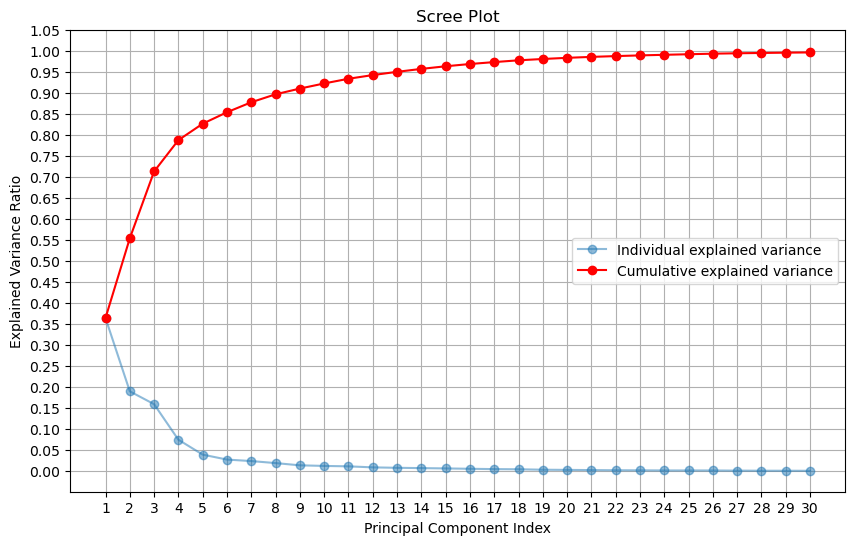

In [87]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

def apply_pca(df, y_column, n_components=None):
    X = df.drop(y_column, axis=1)

    # ใช้ StandardScaler เพื่อทำ scaling ข้อมูล
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ใช้ PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # สร้าง DataFrame ใหม่ที่มี components ของ PCA และ target
    columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=columns)
    df_pca[y_column] = df[y_column].values

    return df_pca, pca

def plot_scree(pca):
    var_ratio = pca.explained_variance_ratio_
    cum_var_ratio = var_ratio.cumsum()
    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(var_ratio) + 1), var_ratio, marker='o', linestyle='-', alpha=0.5, label='Individual explained variance')
    plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, marker='o', color='red', linestyle='-', label='Cumulative explained variance')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component Index')
    plt.xticks(range(1, len(var_ratio) + 1))
    plt.yticks(np.arange(0, 1.1, 0.05))  # Adjusting y-axis ticks
    plt.grid(True)  # Adding grid
    plt.legend(loc='best')
    plt.title('Scree Plot')
    plt.show()



# ตัวอย่างการใช้งาน
df_pca_trial, pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=30)
plot_scree(pca_model_trial)

df_pca_5_comp = df_pca_trial, pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=5)
df_pca_15_comp = df_pca_trial, pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=5)
df_pca_10_comp = df_pca_trial, pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=5)



In [88]:
df_pca_5_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=5)
df_pca_10_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=10)
df_pca_15_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=15)
df_pca_20_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=20)

## Stepwise Ft Selection


In [97]:
from sklearn.linear_model import LogisticRegression

# Other imports remain the same

def stepwise_selection(df, y_column):
    X = df.drop(y_column, axis=1)
    y = df[y_column]

    models = {
        'LGBM': LGBMClassifier(verbose=-1),
        'GradientBoosting': GradientBoostingClassifier(),
        'RandomForest': RandomForestClassifier(),
        'LogisticRegression_L2': LogisticRegression(penalty='l2', solver='lbfgs'),
        'LogisticRegression_L1': LogisticRegression(penalty='l1', solver='liblinear'),
        'LogisticRegression_ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5),
        'GaussianNB': GaussianNB(),
        'SVM': SVC()
    }

    selected_features = {}
    model_scores = {}

    for model_name, model in models.items():
        sfs = SFS(model, 
                  k_features=(3, len(X.columns)),  # Range of features to consider
                  forward=True, 
                  floating=True,  # Enable both adding and removing features
                  scoring='roc_auc',
                  cv=5)

        sfs.fit(X, y)
        selected_features[model_name] = X.columns[list(sfs.k_feature_idx_)]
        model_scores[model_name] = sfs.k_score_

    return selected_features, model_scores

model_ft_dict = dict()
# Example usage
selected_features_by_model, model_scores = stepwise_selection(robust_tf_df, 'y')
for model, features in selected_features_by_model.items():
    print(f"Selected features for {model}: {features}")
    print(f"Score for {model}: {model_scores[model]}")
    model_ft_dict[model] = list(features)
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")


In [90]:
list(model_ft_dict['LGBM'])

['RSI_15', 'SET_Close', 'Close_pct_change', 'EMA_25']

In [91]:
for k,v in model_ft_dict.items():
    # print(k,v)
    # print(f"""stepwise_{k.lower()}_df = robust_tf_df[model_ft_dict['{k}'] + ['y']] """)
    print(f"""stepwise_{k.lower()}_df""")
stepwise_lgbm_df = robust_tf_df[model_ft_dict['LGBM'] + ['y']]
stepwise_lgbm_df = robust_tf_df[model_ft_dict['LGBM'] + ['y']] 
stepwise_gradientboosting_df = robust_tf_df[model_ft_dict['GradientBoosting'] + ['y']] 
stepwise_randomforest_df = robust_tf_df[model_ft_dict['RandomForest'] + ['y']] 
stepwise_logisticregression_l2_df = robust_tf_df[model_ft_dict['LogisticRegression_L2'] + ['y']] 
stepwise_logisticregression_l1_df = robust_tf_df[model_ft_dict['LogisticRegression_L1'] + ['y']] 
stepwise_logisticregression_elasticnet_df = robust_tf_df[model_ft_dict['LogisticRegression_ElasticNet'] + ['y']] 
stepwise_gaussiannb_df = robust_tf_df[model_ft_dict['GaussianNB'] + ['y']] 
stepwise_svm_df = robust_tf_df[model_ft_dict['SVM'] + ['y']] 

stepwise_lgbm_df
stepwise_gradientboosting_df
stepwise_randomforest_df
stepwise_logisticregression_l2_df
stepwise_logisticregression_l1_df
stepwise_logisticregression_elasticnet_df
stepwise_gaussiannb_df
stepwise_svm_df


## Domain Knowledge Ft selection

In [92]:
# pd.set_option('display.max_rows', None)
# display(robust_tf_df.columns.to_frame())
# pd.reset_option('display.max_rows')

In [93]:
dm_cols_selected = ['y'
                    ,'RSI_15'
,'SET_Close'
,'MACD'
,'Close_pct_change'
,'EMA_25'
,'ERW.BK_Close'
]

manual_domain_selection_df = robust_tf_df[dm_cols_selected ]
manual_domain_selection_df.head(3)

,y,RSI_15,SET_Close,MACD,Close_pct_change,EMA_25,ERW.BK_Close
Datetime,,,,,,,
2023-11-10 15:15:00,-1,0.263879,-0.049760,-0.031553,0.000000,-0.945674,-0.666666
2023-11-10 15:30:00,-1,-0.213607,-0.023178,-0.094557,-0.009804,-0.955782,-0.999997
2023-11-10 15:45:00,-1,-0.213607,-0.203817,-0.143856,0.000000,-0.965113,-0.999997


# Modeling

In [94]:
# raise SystemExit("Stopping notebook execution")


# Tree Base

### LGBM

In [95]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

def lgbm_random_search_cv(df, y_column):
    # Data preparation
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    split_index = int(0.8 * len(df))
    X_train = df.iloc[:split_index].drop(y_column, axis=1)
    y_train = df.iloc[:split_index][y_column]
    X_test = df.iloc[split_index:].drop(y_column, axis=1)
    y_test = df.iloc[split_index:][y_column]

# df_test = df.iloc[split_index:]
# df = df.iloc[:split_index]
# print(len(df) , len(df_test))
    
    tscv = TimeSeriesSplit(n_splits=5)

    # Define hyperparameters for random search
    param_dist = {
        'num_leaves': [20, 30, 50, 70, 100],
        'max_depth': [5, 10, 15, 20, 30],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200, 300, 500],
        'min_child_weight': [0.001, 0.01, 0.1, 1, 10],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
    }

    # LightGBM model
    lgbm = LGBMClassifier(objective='binary', random_state=42,verbosity=-1)

    # RandomizedSearchCV
    rscv = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=100, scoring='roc_auc', cv=tscv, verbose=1, random_state=42, n_jobs=-1)
    rscv.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters found: ", rscv.best_params_)
    print("Best ROC-AUC score found: ", rscv.best_score_)
    
    # Optionally, evaluate on the test set
    test_score = rscv.score(X_test, y_test)
    print("ROC-AUC on test set: ", test_score)
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    


lgbm_random_search_cv(df_pca_5_comp, 'y')
lgbm_random_search_cv(df_pca_15_comp, 'y')
lgbm_random_search_cv(df_pca_20_comp, 'y')
lgbm_random_search_cv(robust_tf_df, 'y')
lgbm_random_search_cv(robust_tf_rfe_df, 'y')
lgbm_random_search_cv(robust_tf_ftimp_mulcorr_df, 'y')
lgbm_random_search_cv(manual_domain_selection_df, 'y')
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
lgbm_random_search_cv(stepwise_lgbm_df, 'y')
lgbm_random_search_cv(stepwise_gradientboosting_df, 'y')
lgbm_random_search_cv(stepwise_randomforest_df, 'y')
lgbm_random_search_cv(stepwise_logisticregression_l2_df, 'y')
lgbm_random_search_cv(stepwise_logisticregression_l1_df, 'y')
lgbm_random_search_cv(stepwise_logisticregression_elasticnet_df, 'y')
lgbm_random_search_cv(stepwise_gaussiannb_df, 'y')
lgbm_random_search_cv(stepwise_svm_df, 'y')


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters found:  {'subsample': 0.8, 'num_leaves': 30, 'n_estimators': 200, 'min_child_weight': 0.1, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best ROC-AUC score found:  0.676869115220619
ROC-AUC on test set:  0.5551219512195122
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'subsample': 0.8, 'num_leaves': 100, 'n_estimators': 50, 'min_child_weight': 0.01, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best ROC-AUC score found:  0.6467515979396975
ROC-AUC on test set:  0.6609756097560976
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'subsample': 0.9, 'num_leaves': 30, 'n_estimators': 50, 'min_child_weight': 0.01, 'max_depth': 20, 'learning_rate': 0.2, 'colsample_bytre

### Gradient Boosting

In [96]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
import numpy as np

def xgb_bayesian_optimization(df, y_column, vb = 0):
    df[y_column] = df[y_column].replace(-1, 0)
    # แยกข้อมูลเป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

    # แยกชุดฝึกและชุดทดสอบ
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    split_index = int(0.8 * len(df))
    X_train = df.iloc[:split_index].drop(y_column, axis=1)
    y_train = df.iloc[:split_index][y_column]
    X_test = df.iloc[split_index:].drop(y_column, axis=1)
    y_test = df.iloc[split_index:][y_column]

    tscv = TimeSeriesSplit(n_splits=5)
    # ฟังก์ชันสำหรับ Cross-Validation และการคำนวณ ROC-AUC
    def xgb_evaluate(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        params = {'max_depth': int(max_depth),
                  'learning_rate': learning_rate,
                  'n_estimators': int(n_estimators),
                  'gamma': gamma,
                  'min_child_weight': min_child_weight,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'objective': 'binary:logistic'}
        xgb = XGBClassifier(**params)
        cv_scores = cross_val_score(xgb, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters
    params_bounds = {
    'max_depth': (3, 150),  # ขยายเป็น 3 ถึง 150
    'learning_rate': (0.001, 0.5),  # ขยายเป็น 0.001 ถึง 0.5
    'n_estimators': (50, 500),  # ขยายเป็น 50 ถึง 500
    'gamma': (0, 10),  # ขยายเป็น 0 ถึง 10
    'min_child_weight': (0, 10),  # ขยายเป็น 0 ถึง 10
    'subsample': (0.5, 1.0),  # ขยายช่วง subsample
    'colsample_bytree': (0.5, 1.0)  # ขยายช่วง colsample_bytree
    }

    # Bayesian Optimization
    xgb_bo = BayesianOptimization(xgb_evaluate, params_bounds, random_state=42, verbose = 0)
    xgb_bo.maximize(init_points=5, n_iter=100 )

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = xgb_bo.max['params']
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_model = XGBClassifier(**best_params)
    best_model.fit(X_train, y_train)

    # ทำ Cross-Validation และแสดงคะแนนสำหรับทุกรอบ
    cv_scores = cross_val_score(best_model, X, y, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    return best_model

xgb_bayesian_optimization(df_pca_5_comp, 'y')
xgb_bayesian_optimization(df_pca_15_comp, 'y')
xgb_bayesian_optimization(df_pca_20_comp, 'y')
xgb_bayesian_optimization(robust_tf_df, 'y')
xgb_bayesian_optimization(robust_tf_rfe_df, 'y')
xgb_bayesian_optimization(robust_tf_ftimp_mulcorr_df, 'y')
xgb_bayesian_optimization(manual_domain_selection_df, 'y')
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
xgb_bayesian_optimization(stepwise_lgbm_df, 'y')
xgb_bayesian_optimization(stepwise_gradientboosting_df, 'y')
xgb_bayesian_optimization(stepwise_randomforest_df, 'y')
xgb_bayesian_optimization(stepwise_logisticregression_l2_df, 'y')
xgb_bayesian_optimization(stepwise_logisticregression_l1_df, 'y')
xgb_bayesian_optimization(stepwise_logisticregression_elasticnet_df, 'y')
xgb_bayesian_optimization(stepwise_gaussiannb_df, 'y')
xgb_bayesian_optimization(stepwise_svm_df, 'y')


Cross-Validation Scores:  [0.5965203  0.69563492 0.59908676 0.60720486 0.60163468]
Average CV Score:  0.6200163043442568
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


KeyboardInterrupt: 

### Random Forest

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
import numpy as np

def rf_bayesian_optimization(df, y_column, vb=0):
    # แยกข้อมูลเป็น features และ target
    df[y_column] = df[y_column].replace(-1, 0)

    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

    # แยกชุดฝึกและชุดทดสอบ
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    split_index = int(0.8 * len(df))
    X_train = df.iloc[:split_index].drop(y_column, axis=1)
    y_train = df.iloc[:split_index][y_column]
    X_test = df.iloc[split_index:].drop(y_column, axis=1)
    y_test = df.iloc[split_index:][y_column]
    
    tscv = TimeSeriesSplit(n_splits=5)
    # ฟังก์ชันสำหรับ Cross-Validation และการคำนวณ ROC-AUC สำหรับ RandomForest
    def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
        params = {
            'n_estimators': int(n_estimators),
            'max_depth': int(max_depth),
            'min_samples_split': int(min_samples_split),
            'min_samples_leaf': int(min_samples_leaf),
            'random_state': 42
        }
        rf = RandomForestClassifier(**params)
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = cross_val_score(rf, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters สำหรับ RandomForest
    params_bounds = {
        'n_estimators': (100, 500),
        'max_depth': (10, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4)
    }

    # Bayesian Optimization
    rf_bo = BayesianOptimization(rf_evaluate, params_bounds, random_state=42, verbose=0)
    rf_bo.maximize(init_points=5, n_iter=100 )

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = rf_bo.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_samples_split'] = int(best_params['min_samples_split'])
    best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
    best_model = RandomForestClassifier(**best_params)
    best_model.fit(X_train, y_train)

    # ทำ Cross-Validation และแสดงคะแนนสำหรับทุกรอบ
    cv_scores = cross_val_score(best_model, X, y, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    return best_model

rf_bayesian_optimization(df_pca_5_comp, 'y')
rf_bayesian_optimization(df_pca_15_comp, 'y')
rf_bayesian_optimization(df_pca_20_comp, 'y')
rf_bayesian_optimization(robust_tf_df, 'y')
rf_bayesian_optimization(robust_tf_rfe_df, 'y')
rf_bayesian_optimization(robust_tf_ftimp_mulcorr_df, 'y')
rf_bayesian_optimization(manual_domain_selection_df, 'y')
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
rf_bayesian_optimization(stepwise_lgbm_df, 'y')
rf_bayesian_optimization(stepwise_gradientboosting_df, 'y')
rf_bayesian_optimization(stepwise_randomforest_df, 'y')
rf_bayesian_optimization(stepwise_logisticregression_l2_df, 'y')
rf_bayesian_optimization(stepwise_logisticregression_l1_df, 'y')
rf_bayesian_optimization(stepwise_logisticregression_elasticnet_df, 'y')
rf_bayesian_optimization(stepwise_gaussiannb_df, 'y')
rf_bayesian_optimization(stepwise_svm_df, 'y')

Cross-Validation Scores:  [0.62386081 0.76031746 0.65388128 0.609375   0.63823738]
Average CV Score:  0.6571343870585441
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.6097763  0.69285714 0.70136986 0.61458333 0.69509595]
Average CV Score:  0.6627365185839238
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.65202983 0.73095238 0.62374429 0.57291667 0.56858564]
Average CV Score:  0.6296457618167824
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.69676885 0.69365079 0.67031963 0.64322917 0.66879886]
Average CV Score:  0.6745534612467589
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.68434134 0.68492063 0.73881279 0.55121528 0.73347548]
Average CV Score:  0.6785531040002695
@@@@@@@

RandomForestClassifier(max_depth=28, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=491)

# Logistic Regression


In [ ]:
df_pca_5_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=5)
df_pca_10_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=10)
df_pca_15_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=15)
df_pca_20_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=20)

### L1

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd

def logistic_regression_bayesian_optimization_l1(df, y_column):
    df[y_column] = df[y_column].replace(-1, 0)

    # แยกข้อมูลเป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

    # แยกชุดฝึกและชุดทดสอบ
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    split_index = int(0.8 * len(df))
    X_train = df.iloc[:split_index].drop(y_column, axis=1)
    y_train = df.iloc[:split_index][y_column]
    X_test = df.iloc[split_index:].drop(y_column, axis=1)
    y_test = df.iloc[split_index:][y_column]
    tscv = TimeSeriesSplit(n_splits=5)

    def logistic_evaluate(C):
        params = {
            'penalty': 'l1',
            'C': C,
            'solver': 'saga',
            'max_iter': 1000000,
            'random_state': 42
        }
        logistic = LogisticRegression(**params)
        cv_scores = cross_val_score(logistic, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters
    params_bounds = {
        'C': (0.001, 10000)
    }

    # Bayesian Optimization
    logistic_bo = BayesianOptimization(logistic_evaluate, params_bounds, random_state=42, allow_duplicate_points=True, verbose=0)
    logistic_bo.maximize(init_points=5, n_iter=100)

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = logistic_bo.max['params']
    best_params['penalty'] = 'l1'
    best_params['solver'] = 'saga'
    best_model = LogisticRegression(**best_params)
    best_model.fit(X_train, y_train)

    # ทำ Cross-Validation และแสดงคะแนนสำหรับทุกรอบ
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    return best_model

logistic_regression_bayesian_optimization_l1(df_pca_5_comp, 'y')
logistic_regression_bayesian_optimization_l1(df_pca_15_comp, 'y')
logistic_regression_bayesian_optimization_l1(df_pca_20_comp, 'y')
logistic_regression_bayesian_optimization_l1(robust_tf_df, 'y')
logistic_regression_bayesian_optimization_l1(robust_tf_rfe_df, 'y')
logistic_regression_bayesian_optimization_l1(robust_tf_ftimp_mulcorr_df, 'y')
logistic_regression_bayesian_optimization_l1(manual_domain_selection_df, 'y')
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
logistic_regression_bayesian_optimization_l1(stepwise_lgbm_df, 'y')
logistic_regression_bayesian_optimization_l1(stepwise_gradientboosting_df, 'y')
logistic_regression_bayesian_optimization_l1(stepwise_randomforest_df, 'y')
logistic_regression_bayesian_optimization_l1(stepwise_logisticregression_l2_df, 'y')
logistic_regression_bayesian_optimization_l1(stepwise_logisticregression_l1_df, 'y')
logistic_regression_bayesian_optimization_l1(stepwise_logisticregression_elasticnet_df, 'y')
logistic_regression_bayesian_optimization_l1(stepwise_gaussiannb_df, 'y')
logistic_regression_bayesian_optimization_l1(stepwise_svm_df, 'y')

/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.58666667 0.76248313 0.69132653 0.61538462 0.61063218]
Average CV Score:  0.6532986254951513
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.62787879 0.76248313 0.76658163 0.67206478 0.61781609]
Average CV Score:  0.6893648841435982
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.65212121 0.7611336  0.76658163 0.65047233 0.55890805]
Average CV Score:  0.6778433657346025
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.67636364 0.73954116 0.77806122 0.6977058  0.55172414]
Average CV Score:  0.6886791924694439
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.53454545 0.81106613 0.74234694 0.67746289 0.62068966]
Average CV Score:  0.6772222126676366
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.56121212 0.74224022 0.62755102 0.61538462 0.57471264]
Average CV Score:  0.6242201233214975
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.53454545 0.83535762 0.74107143 0.62618084 0.59482759]
Average CV Score:  0.6663965861724483
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

LogisticRegression(C=3745.4018139335058, penalty='l1', solver='saga')

### L2

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd

def logistic_regression_bayesian_optimization_l2(df, y_column):
    df[y_column] = df[y_column].replace(-1, 0)

    # แยกข้อมูลเป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

    # แยกชุดฝึกและชุดทดสอบ
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    split_index = int(0.8 * len(df))
    X_train = df.iloc[:split_index].drop(y_column, axis=1)
    y_train = df.iloc[:split_index][y_column]
    X_test = df.iloc[split_index:].drop(y_column, axis=1)
    y_test = df.iloc[split_index:][y_column]
    tscv = TimeSeriesSplit(n_splits=5)

    def logistic_evaluate(C):
        params = {
            'penalty': 'l2',
            'C': C,
            'solver': 'lbfgs',
            'max_iter': 1000000,
            'random_state': 42
        }
        logistic = LogisticRegression(**params)
        cv_scores = cross_val_score(logistic, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters
    params_bounds = {
        'C': (0.001, 10000)
    }

    # Bayesian Optimization
    logistic_bo = BayesianOptimization(logistic_evaluate, params_bounds, random_state=42, allow_duplicate_points=True, verbose=0)
    logistic_bo.maximize(init_points=5, n_iter=100)

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = logistic_bo.max['params']
    best_params['penalty'] = 'l2'
    best_params['solver'] = 'lbfgs'
    best_model = LogisticRegression(**best_params)
    best_model.fit(X_train, y_train)

    # ทำ Cross-Validation และแสดงคะแนนสำหรับทุกรอบ
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    return best_model

# ตัวอย่างการใช้งาน
logistic_regression_bayesian_optimization_l2(df_pca_5_comp, 'y')
logistic_regression_bayesian_optimization_l2(df_pca_15_comp, 'y')
logistic_regression_bayesian_optimization_l2(df_pca_20_comp, 'y')
logistic_regression_bayesian_optimization_l2(robust_tf_df, 'y')
logistic_regression_bayesian_optimization_l2(robust_tf_rfe_df, 'y')
logistic_regression_bayesian_optimization_l2(robust_tf_ftimp_mulcorr_df, 'y')
logistic_regression_bayesian_optimization_l2(manual_domain_selection_df, 'y')
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
logistic_regression_bayesian_optimization_l2(stepwise_lgbm_df, 'y')
logistic_regression_bayesian_optimization_l2(stepwise_gradientboosting_df, 'y')
logistic_regression_bayesian_optimization_l2(stepwise_randomforest_df, 'y')
logistic_regression_bayesian_optimization_l2(stepwise_logisticregression_l2_df, 'y')
logistic_regression_bayesian_optimization_l2(stepwise_logisticregression_l1_df, 'y')
logistic_regression_bayesian_optimization_l2(stepwise_logisticregression_elasticnet_df, 'y')
logistic_regression_bayesian_optimization_l2(stepwise_gaussiannb_df, 'y')
logistic_regression_bayesian_optimization_l2(stepwise_svm_df, 'y')

Cross-Validation Scores:  [0.62909091 0.78002699 0.67091837 0.64777328 0.59913793]
Average CV Score:  0.6653894954755727
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.64484848 0.80026991 0.78316327 0.69230769 0.60632184]
Average CV Score:  0.7053822374151645
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.65212121 0.80431849 0.7869898  0.6977058  0.58764368]
Average CV Score:  0.7057557955396948
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.64       0.76518219 0.79081633 0.73144399 0.5933908 ]
Average CV Score:  0.7041666623930041
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Cross-Validation Scores:  [0.54424242 0.82591093 0.75382653 0.68825911 0.62068966]
Average CV Score:  0.6865857301025826
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.57090909 0.74224022 0.62755102 0.61538462 0.57471264]
Average CV Score:  0.6261595172608914
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.62787879 0.82186235 0.70535714 0.63967611 0.60775862]
Average CV Score:  0.6805066025928095
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


LogisticRegression(C=0.3124702711773379)

## Elastic net

In [ ]:
def logistic_regression_bayesian_optimization_elasticnet(df, y_column):
    df[y_column] = df[y_column].replace(-1, 0)

    # แยกข้อมูลเป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

    # แยกชุดฝึกและชุดทดสอบ
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    split_index = int(0.8 * len(df))
    X_train = df.iloc[:split_index].drop(y_column, axis=1)
    y_train = df.iloc[:split_index][y_column]
    X_test = df.iloc[split_index:].drop(y_column, axis=1)
    y_test = df.iloc[split_index:][y_column]
    tscv = TimeSeriesSplit(n_splits=5)

    def logistic_evaluate(C, l1_ratio):
        params = {
            'penalty': 'elasticnet',
            'C': C,
            'solver': 'saga',  # Solver ที่รองรับ elasticnet
            'l1_ratio': l1_ratio,
            'max_iter': 1000000,
            'random_state': 42
        }
        logistic = LogisticRegression(**params)
        cv_scores = cross_val_score(logistic, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters
    params_bounds = {
        'C': (0.001, 10000),
        'l1_ratio': (0, 1)  # ช่วงของ l1_ratio สำหรับ elasticnet
    }

    # Bayesian Optimization
    logistic_bo = BayesianOptimization(logistic_evaluate, params_bounds, random_state=42, allow_duplicate_points=True, verbose=0)
    logistic_bo.maximize(init_points=5, n_iter=100)

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = logistic_bo.max['params']
    best_params['penalty'] = 'elasticnet'
    best_params['solver'] = 'saga'
    best_model = LogisticRegression(**best_params)
    best_model.fit(X_train, y_train)

    # ทำ Cross-Validation และแสดงคะแนนสำหรับทุกรอบ
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    return best_model

# ตัวอย่างการใช้งาน
logistic_regression_bayesian_optimization_elasticnet(df_pca_5_comp, 'y')
logistic_regression_bayesian_optimization_elasticnet(df_pca_15_comp, 'y')
logistic_regression_bayesian_optimization_elasticnet(df_pca_20_comp, 'y')
logistic_regression_bayesian_optimization_elasticnet(robust_tf_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(robust_tf_rfe_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(robust_tf_ftimp_mulcorr_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(manual_domain_selection_df, 'y')
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
logistic_regression_bayesian_optimization_elasticnet(stepwise_lgbm_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(stepwise_gradientboosting_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(stepwise_randomforest_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(stepwise_logisticregression_l2_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(stepwise_logisticregression_l1_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(stepwise_logisticregression_elasticnet_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(stepwise_gaussiannb_df, 'y')
logistic_regression_bayesian_optimization_elasticnet(stepwise_svm_df, 'y')

/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.66666667 0.7611336  0.67984694 0.64102564 0.59195402]
Average CV Score:  0.668125374539038
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.63030303 0.79352227 0.78443878 0.68960864 0.61206897]
Average CV Score:  0.7019883351028022
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.65939394 0.76788124 0.77040816 0.65182186 0.56034483]
Average CV Score:  0.6819700068318164
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.67515152 0.73954116 0.77806122 0.70175439 0.55028736]
Average CV Score:  0.6889591285043709
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.5369697  0.81106613 0.74107143 0.67881242 0.62068966]
Average CV Score:  0.6777218646447322
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.56121212 0.74224022 0.62755102 0.61538462 0.57471264]
Average CV Score:  0.6242201233214975
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.53575758 0.83805668 0.74107143 0.62887989 0.59626437]
Average CV Score:  0.6680059888689652
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

LogisticRegression(C=7318.2209718323875, l1_ratio=0.9883606531880464,
                   penalty='elasticnet', solver='saga')

# SVM

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from bayes_opt import BayesianOptimization
import numpy as np

def svm_bayesian_optimization(df, y_column):
    df[y_column] = df[y_column].replace(-1, 0)

    # แยกข้อมูลเป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

    # แยกชุดฝึกและชุดทดสอบ
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    split_index = int(0.8 * len(df))
    X_train = df.iloc[:split_index].drop(y_column, axis=1)
    y_train = df.iloc[:split_index][y_column]
    X_test = df.iloc[split_index:].drop(y_column, axis=1)
    y_test = df.iloc[split_index:][y_column]
    tscv = TimeSeriesSplit(n_splits=5)
    def svm_evaluate(C, gamma):
        params = {
            'C': C,
            'gamma': gamma,
            'kernel': 'rbf',  # ใช้ Radial Basis Function (RBF) kernel
            'random_state': 42
        }
        svm = SVC(**params)
        cv_scores = cross_val_score(svm, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters สำหรับ SVM
    params_bounds = {
        'C': (0.1, 100),
        'gamma': (0.001, 1)
    }

    # Bayesian Optimization
    svm_bo = BayesianOptimization(svm_evaluate, params_bounds, random_state=42, allow_duplicate_points=True, verbose=0)
    svm_bo.maximize(init_points=5, n_iter=100)

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = svm_bo.max['params']
    best_model = SVC(**best_params, kernel='rbf', random_state=42)
    best_model.fit(X_train, y_train)

    # ทำ Cross-Validation และแสดงคะแนนสำหรับทุกรอบ
    cv_scores = cross_val_score(best_model, X, y, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    return best_model

# ใช้งานฟังก์ชัน
svm_bayesian_optimization(df_pca_5_comp, 'y')
svm_bayesian_optimization(df_pca_15_comp, 'y')
svm_bayesian_optimization(df_pca_20_comp, 'y')
svm_bayesian_optimization(robust_tf_df, 'y')
svm_bayesian_optimization(robust_tf_rfe_df, 'y')
svm_bayesian_optimization(robust_tf_ftimp_mulcorr_df, 'y')
svm_bayesian_optimization(manual_domain_selection_df, 'y')
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
svm_bayesian_optimization(stepwise_lgbm_df, 'y')
svm_bayesian_optimization(stepwise_gradientboosting_df, 'y')
svm_bayesian_optimization(stepwise_randomforest_df, 'y')
svm_bayesian_optimization(stepwise_logisticregression_l2_df, 'y')
svm_bayesian_optimization(stepwise_logisticregression_l1_df, 'y')
svm_bayesian_optimization(stepwise_logisticregression_elasticnet_df, 'y')
svm_bayesian_optimization(stepwise_gaussiannb_df, 'y')
svm_bayesian_optimization(stepwise_svm_df, 'y')


Cross-Validation Scores:  [0.65120133 0.79444444 0.38173516 0.64670139 0.59488273]
Average CV Score:  0.6137930095924871
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.68351284 0.71269841 0.67214612 0.63368056 0.58137882]
Average CV Score:  0.6566833497833281
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.71582436 0.75238095 0.65388128 0.6640625  0.62046908]
Average CV Score:  0.681323634397519
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.67771334 0.70793651 0.72511416 0.64930556 0.58493248]
Average CV Score:  0.6690004076109486
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.67357084 0.73809524 0.72054795 0.64930556 0.40156361]
Average CV Score:  0.6366166372321053
@@@@@@@@

SVC(C=14.019505481047146, gamma=0.12544979393743136, random_state=42)

# Gaussian NB

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit

def gaussian_naive_bayes(df, y_column):
    df[y_column] = df[y_column].replace(-1, 0)

    # Split data into features and target
    X = df.drop(y_column, axis=1)
    y = df[y_column]

    # Split the dataset
    split_index = int(0.8 * len(df))
    X_train = df.iloc[:split_index].drop(y_column, axis=1)
    y_train = df.iloc[:split_index][y_column]
    X_test = df.iloc[split_index:].drop(y_column, axis=1)
    y_test = df.iloc[split_index:][y_column]

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Create Gaussian Naive Bayes model and adjust var_smoothing
    gnb = GaussianNB(var_smoothing=1e-9)
    gnb.fit(X_train, y_train)

    # Perform Cross-Validation and print scores
    cv_scores = cross_val_score(gnb, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

    return gnb


# ใช้งานฟังก์ชัน
gaussian_naive_bayes(df_pca_5_comp, 'y')
gaussian_naive_bayes(df_pca_15_comp, 'y')
gaussian_naive_bayes(df_pca_20_comp, 'y')
gaussian_naive_bayes(robust_tf_df, 'y')
gaussian_naive_bayes(robust_tf_rfe_df, 'y')
gaussian_naive_bayes(robust_tf_ftimp_mulcorr_df, 'y')
gaussian_naive_bayes(manual_domain_selection_df, 'y')
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
gaussian_naive_bayes(stepwise_lgbm_df, 'y')
gaussian_naive_bayes(stepwise_gradientboosting_df, 'y')
gaussian_naive_bayes(stepwise_randomforest_df, 'y')
gaussian_naive_bayes(stepwise_logisticregression_l2_df, 'y')
gaussian_naive_bayes(stepwise_logisticregression_l1_df, 'y')
gaussian_naive_bayes(stepwise_logisticregression_elasticnet_df, 'y')
gaussian_naive_bayes(stepwise_gaussiannb_df, 'y')
gaussian_naive_bayes(stepwise_svm_df, 'y')


Cross-Validation Scores:  [0.67757576 0.79757085 0.71811224 0.62753036 0.56465517]
Average CV Score:  0.6770888778924818
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.58060606 0.73144399 0.67984694 0.67206478 0.5933908 ]
Average CV Score:  0.6514705151818193
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.6169697  0.69905533 0.69515306 0.68690958 0.51293103]
Average CV Score:  0.6422037409915294
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.70424242 0.71524966 0.68239796 0.67746289 0.57471264]
Average CV Score:  0.6708131155423093
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.67636364 0.73414305 0.64285714 0.73144399 0.55172414]
Average CV Score:  0.6673063923372453
@@@@@@@

GaussianNB()

# Evaluation